# Jupyter Notebook Purpose

- Preliminary ML learning will need to be done
    - a couple of models are attempted and an ensemble is created from the best performing models

## Group 2 Members

- 1. Melissa Hartwick - [Email](mailto:mhartwic@uwaterloo.ca)
- 2. McKinleigh Needham - [Email](mailto:mjneedha@uwaterloo.ca)
- 3. Daniel Adam Cebula  - [Email](mailto:dacebula@uwaterloo.ca)
- 4. Athithian Selvadurai - [Email](mailto:a6selvad@uwaterloo.ca)
- 5. Aravind Kakarala - [Email](mailto:akakaral@uwaterloo.ca)
- 6. Allan Sales - [Email](mailto:asales@uwaterloo.ca)

In [1]:
import pandas as pd
import numpy as np
import os
import requests  # simple HTTP library for Python
import io        # Tool for working with streams (Input/Ouput data)
import matplotlib.pyplot as plt
import glob
import time

%matplotlib inline

# some matplotlib defaults
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
# Get FilePaths
cwd = os.getcwd()

Final_Data_Directory = os.path.join(cwd, "FINAL_DATA")

Final_Data = os.path.join(Final_Data_Directory, "2014-2019-TTC-Delay-Data-ML.csv")

In [3]:
# Load the Final Data into DataFrames
df = pd.read_csv(Final_Data, low_memory=False)
df.sample(5)

,Identity,Hour,MonthName,DayName,HolidayName,Incident,Temp (°C),Precip. Amount (mm),Wind Dir (10s deg),Wind Spd (km/h),Stn Press (kPa),Min Delay,Min Gap
489592,Bus,14,August,Tuesday,Not A Holiday,Mechanical,28.73,0.0,25.5,24.5,99.88,8,16
592262,Streetcar,19,June,Thursday,Not A Holiday,Route Problems,16.97,0.0,12.5,16.5,100.32,23,28
210773,Bus,13,December,Saturday,Not A Holiday,Route Problems,5.00,0.0,18.5,19.5,101.08,5,11
380000,Bus,17,February,Tuesday,Not A Holiday,Route Problems,6.97,0.0,8.0,15.5,99.76,20,40
106075,Subway,20,January,Monday,Not A Holiday,Mechanical,-12.77,0.0,31.5,17.5,101.88,0,0


In [4]:
# continuous variables
continuous = ["Temp (°C)", "Precip. Amount (mm)", "Wind Dir (10s deg)",
              "Wind Spd (km/h)", "Stn Press (kPa)"]

# categorical variables
categorical_ml = ["Identity", "Hour", "MonthName", "DayName", "HolidayName", "Incident"]

# turn each attribute into categorical
for x in categorical_ml:
    df[x] = df[x].astype("category")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653736 entries, 0 to 653735
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   Identity             653736 non-null  category
 1   Hour                 653736 non-null  category
 2   MonthName            653736 non-null  category
 3   DayName              653736 non-null  category
 4   HolidayName          653736 non-null  category
 5   Incident             653736 non-null  category
 6   Temp (°C)            653736 non-null  float64 
 7   Precip. Amount (mm)  653736 non-null  float64 
 8   Wind Dir (10s deg)   653736 non-null  float64 
 9   Wind Spd (km/h)      653736 non-null  float64 
 10  Stn Press (kPa)      653736 non-null  float64 
 11  Min Delay            653736 non-null  int64   
 12  Min Gap              653736 non-null  int64   
dtypes: category(6), float64(5), int64(2)
memory usage: 38.7 MB


# Preliminary Machine Learning Imports

In [6]:
# Split data into Training and Testing data
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

# Scale the data
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# Scikit pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Search for best hyperparameters
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Feature Reduction
from sklearn.decomposition import PCA

# ML Models
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Ensemble
from sklearn.ensemble import VotingClassifier

# Create Categories for Min Delay and Min Gap

- these categories will be used as the labels for "Min Delay" and "Min Gap"

In [7]:
#Limits
min_max = 1440.1
min_min = 0

# Min Delay Category
min_delay = pd.cut(df["Min Delay"],
                   bins=[min_min,3,10,30,60,180,min_max],
                   labels=['0 - 3 minutes','3 - 10 minutes','10 - 30 minutes','30 - 60 minutes', "60 - 180 minutes", ">=180 minutes"],
                   right=False)

# Min Gap Category
min_gap = pd.cut(df["Min Gap"],
                   bins=[min_min,3,10,30,60,180,min_max],
                   labels=['0 - 3 minutes','3 - 10 minutes','10 - 30 minutes','30 - 60 minutes', "60 - 180 minutes", ">=180 minutes"],
                   right=False)

df["Min Delay Category"] = min_delay
df["Min Gap Category"] = min_gap
df.head()

,Identity,Hour,MonthName,DayName,HolidayName,Incident,Temp (°C),Precip. Amount (mm),Wind Dir (10s deg),Wind Spd (km/h),Stn Press (kPa),Min Delay,Min Gap,Min Delay Category,Min Gap Category
0,Subway,0,January,Thursday,Not A Holiday,General,-14.27,0.0,2.0,21.0,101.36,6,12,3 - 10 minutes,10 - 30 minutes
1,Subway,7,January,Thursday,Not A Holiday,Mechanical,-16.80,0.2,3.5,22.5,101.04,0,0,0 - 3 minutes,0 - 3 minutes
2,Subway,7,January,Thursday,Not A Holiday,General,-16.80,0.2,3.5,22.5,101.04,0,0,0 - 3 minutes,0 - 3 minutes
3,Subway,7,January,Thursday,Not A Holiday,Mechanical,-16.80,0.2,3.5,22.5,101.04,3,6,3 - 10 minutes,3 - 10 minutes
4,Subway,7,January,Thursday,Not A Holiday,General,-16.80,0.2,3.5,22.5,101.04,0,0,0 - 3 minutes,0 - 3 minutes


# Remove Categorical / Continuous Variables that performed poorly

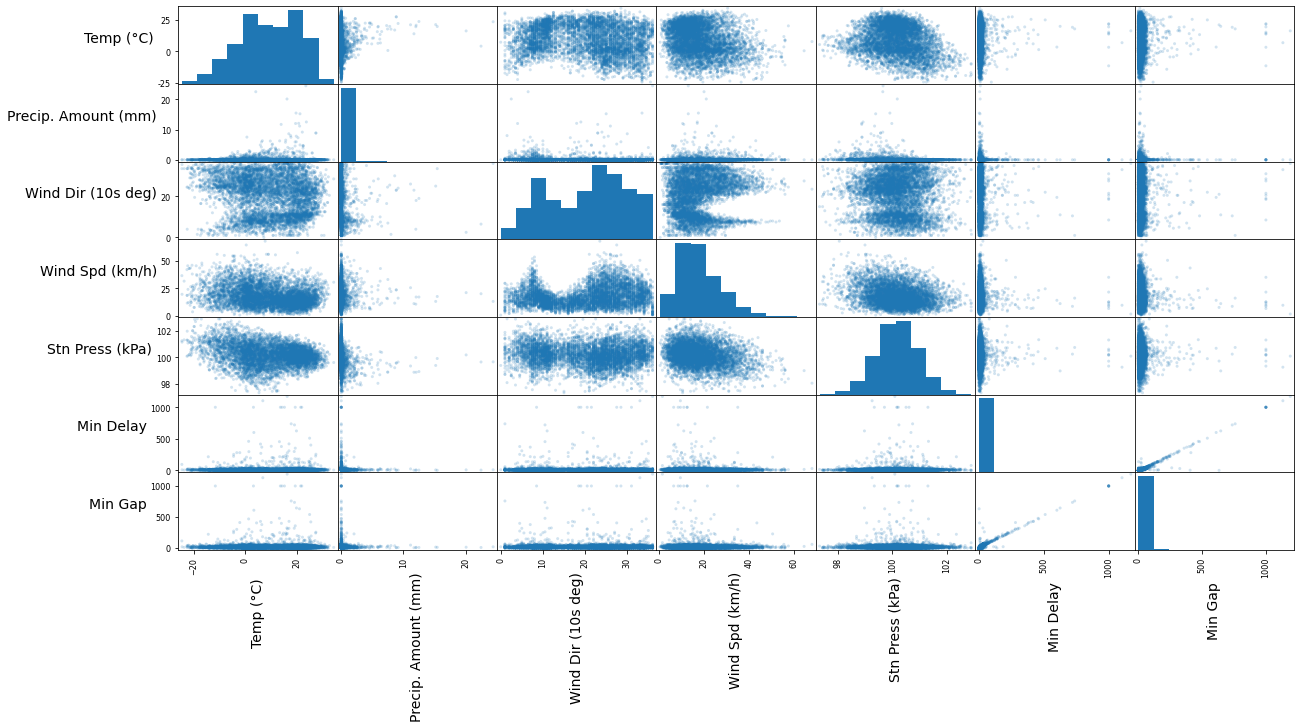

In [8]:
# Scatter Matrix for Continuous Variables
axes = pd.plotting.scatter_matrix(df.loc[::100, continuous + ["Min Delay", "Min Gap"]], alpha=0.2, figsize=(20,10))
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

# Reduce the number of categories in columns for faster computing

In [9]:
# Instead of day name replace with Weekday and Weekend
df["DayName"] = df["DayName"].astype(str)
df.loc[df["DayName"] == "Monday", "DayName"] = "Weekday"
df.loc[df["DayName"] == "Tuesday", "DayName"] = "Weekday"
df.loc[df["DayName"] == "Wednesday", "DayName"] = "Weekday"
df.loc[df["DayName"] == "Thursday", "DayName"] = "Weekday"
df.loc[df["DayName"] == "Friday", "DayName"] = "Weekday"
df.loc[df["DayName"] == "Saturday", "DayName"] = "Weekend"
df.loc[df["DayName"] == "Sunday", "DayName"] = "Weekend"
df["DayName"] = df["DayName"].astype("category")
df["DayName"].unique()

['Weekday', 'Weekend']
Categories (2, object): ['Weekday', 'Weekend']

In [10]:
# Instead of hour instead give it morning, afternoon and night
df["Hour"] = df["Hour"].astype(int)
df["Hour"] = df["Hour"].astype(str)
df.loc[(df["Hour"] == "5") |
       (df["Hour"] == "6") |
       (df["Hour"] == "7") |
       (df["Hour"] == "8") |
       (df["Hour"] == "9") |
       (df["Hour"] == "10") |
       (df["Hour"] == "11")
       , "Hour"] = "Morning"

df.loc[(df["Hour"] == "12") |
       (df["Hour"] == "13") |
       (df["Hour"] == "14") |
       (df["Hour"] == "15") |
       (df["Hour"] == "16") |
       (df["Hour"] == "17") |
       (df["Hour"] == "18") |
       (df["Hour"] == "19") |
       (df["Hour"] == "20") |
       (df["Hour"] == "21") |
       (df["Hour"] == "22")
       , "Hour"] = "Afternoon / Evening"

df.loc[(df["Hour"] == "23") |
       (df["Hour"] == "24") |
       (df["Hour"] == "0") |
       (df["Hour"] == "1") |
       (df["Hour"] == "2") |
       (df["Hour"] == "3") |
       (df["Hour"] == "4")
       , "Hour"] = "Night"

df["Hour"] = df["Hour"].astype("category")
df["Hour"].unique()

['Night', 'Morning', 'Afternoon / Evening']
Categories (3, object): ['Night', 'Morning', 'Afternoon / Evening']

In [11]:
# Instead of the specific holiday name just change it to Holiday
df["HolidayName"] = df["HolidayName"].astype(str)
df.loc[df["HolidayName"] != "Not A Holiday", "HolidayName"] = "Holiday"
df["HolidayName"] = df["HolidayName"].astype("category")
df["HolidayName"].unique()

['Not A Holiday', 'Holiday']
Categories (2, object): ['Not A Holiday', 'Holiday']

In [12]:
# Instead of specific month name just change it to Season
df["MonthName"] = df["MonthName"].astype(str)
df.loc[(df["MonthName"] == "December") |
       (df["MonthName"] == "January") |
       (df["MonthName"] == "February")
       , "MonthName"] = "Winter"

df.loc[(df["MonthName"] == "March") |
       (df["MonthName"] == "April") |
       (df["MonthName"] == "May")
       , "MonthName"] = "Spring"

df.loc[(df["MonthName"] == "June") |
       (df["MonthName"] == "July") |
       (df["MonthName"] == "August")
       , "MonthName"] = "Summer"

df.loc[(df["MonthName"] == "September") |
       (df["MonthName"] == "October") |
       (df["MonthName"] == "November")
       , "MonthName"] = "Fall"

df["MonthName"] = df["MonthName"].astype("category")
df["MonthName"].unique()

['Winter', 'Spring', 'Summer', 'Fall']
Categories (4, object): ['Winter', 'Spring', 'Summer', 'Fall']

In [13]:
# rename the columns
df.rename(columns={"DayName": "Day",
                   "HolidayName": "Holiday",
                   "MonthName": "Season"}, inplace=True)

In [14]:
# Will only look at the following attributes
df = df.loc[:,
      ['Identity', 'Hour', 'Season', 'Day', 'Holiday', 'Incident',
       'Temp (°C)', 'Precip. Amount (mm)',
       'Min Delay Category', 'Min Gap Category']]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653736 entries, 0 to 653735
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   Identity             653736 non-null  category
 1   Hour                 653736 non-null  category
 2   Season               653736 non-null  category
 3   Day                  653736 non-null  category
 4   Holiday              653736 non-null  category
 5   Incident             653736 non-null  category
 6   Temp (°C)            653736 non-null  float64 
 7   Precip. Amount (mm)  653736 non-null  float64 
 8   Min Delay Category   653736 non-null  category
 9   Min Gap Category     653736 non-null  category
dtypes: category(8), float64(2)
memory usage: 15.0 MB


# Machine Learning Pipeline

# 0. Training Process is taking too long

- take only 5% of the data to train ML models on

In [15]:
df_sample = df.sample(frac=0.05, random_state=123).reset_index()
len(df_sample)

32687

### 1. Stratified Train and Test Split

In [16]:
# Stratified Split for Delay Data Categories
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)

for train_index1, test_index1 in split.split(df_sample, df_sample["Min Delay Category"]):
    delay_train_set = df_sample.loc[train_index1]
    delay_test_set = df_sample.loc[test_index1]
    
# Stratified Split for Delay Gap Categories
for train_index2, test_index2 in split.split(df_sample, df_sample["Min Gap Category"]):
    gap_train_set = df_sample.loc[train_index2]
    gap_test_set = df_sample.loc[test_index2]
    
# Create X (features) and y (labels) for both training and testing data
X_train_delay = delay_train_set.drop(['Min Delay Category', 'Min Gap Category'], axis=1)
X_test_delay = delay_test_set.drop(['Min Delay Category', 'Min Gap Category'], axis=1)
y_train_delay = delay_train_set['Min Delay Category']
y_test_delay = delay_test_set['Min Delay Category']

X_train_gap = gap_train_set.drop(['Min Delay Category', 'Min Gap Category'], axis=1)
X_test_gap = gap_test_set.drop(['Min Delay Category', 'Min Gap Category'], axis=1)
y_train_gap = gap_train_set['Min Gap Category']
y_test_gap = gap_test_set['Min Gap Category']

In [17]:
# check to make sure that the training and testing data sets for Delay have the same proportion
(df_sample["Min Delay Category"].value_counts() / len(df_sample),
delay_train_set["Min Delay Category"].value_counts() / len(delay_train_set),
delay_test_set["Min Delay Category"].value_counts() / len(delay_test_set))

(10 - 30 minutes     0.378254
 3 - 10 minutes      0.365925
 0 - 3 minutes       0.191391
 30 - 60 minutes     0.042219
 60 - 180 minutes    0.012604
 >=180 minutes       0.009606
 Name: Min Delay Category, dtype: float64,
 10 - 30 minutes     0.378255
 3 - 10 minutes      0.365903
 0 - 3 minutes       0.191403
 30 - 60 minutes     0.042220
 60 - 180 minutes    0.012620
 >=180 minutes       0.009599
 Name: Min Delay Category, dtype: float64,
 10 - 30 minutes     0.378250
 3 - 10 minutes      0.366014
 0 - 3 minutes       0.191343
 30 - 60 minutes     0.042215
 60 - 180 minutes    0.012542
 >=180 minutes       0.009636
 Name: Min Delay Category, dtype: float64)

In [18]:
# check to make sure that the training and testing data sets for Gap have the same proportion
(df_sample["Min Gap Category"].value_counts() / len(df_sample),
gap_train_set["Min Gap Category"].value_counts() / len(gap_train_set),
gap_test_set["Min Gap Category"].value_counts() / len(gap_test_set))

(10 - 30 minutes     0.487809
 0 - 3 minutes       0.201548
 30 - 60 minutes     0.150794
 3 - 10 minutes      0.112461
 60 - 180 minutes    0.036712
 >=180 minutes       0.010677
 Name: Min Gap Category, dtype: float64,
 10 - 30 minutes     0.487820
 0 - 3 minutes       0.201537
 30 - 60 minutes     0.150790
 3 - 10 minutes      0.112471
 60 - 180 minutes    0.036713
 >=180 minutes       0.010670
 Name: Min Gap Category, dtype: float64,
 10 - 30 minutes     0.487764
 0 - 3 minutes       0.201591
 30 - 60 minutes     0.150811
 3 - 10 minutes      0.112420
 60 - 180 minutes    0.036708
 >=180 minutes       0.010707
 Name: Min Gap Category, dtype: float64)

### 2. One Hot Encode Categorical Variables

In [19]:
# one hot encoding categories
one_hot_categories = [
    "Identity", "Hour", "Season", "Day", "Holiday", "Incident"
]

# categorical data treatment pipeline
categorical_pipe = Pipeline(steps=[
    ('encoder', OneHotEncoder())
])

### 3. Min Max Scale Continuous Variables

In [20]:
# continuous variables
continuous_columns = [
    'Temp (°C)', 'Precip. Amount (mm)'
]

# numerical / continuous data treatment pipeline
continuous_pipe = Pipeline(steps=[
    ("scaler", MinMaxScaler())
])

### 4. Use PCA to reduce dimensions

In [21]:
# perserve 95% of variance
pca = PCA(n_components=0.95)

### 5. Combine everything into a ColumnTransfomer

In [22]:
preprocess = ColumnTransformer(
    transformers=[
    ('continuous', continuous_pipe, continuous_columns),
    ('categorical', categorical_pipe, one_hot_categories)
    ])

### 6. Setup multiple pipelines for preliminary classification

In [23]:
# assemble it with RandomForestClassifier
pipeline_rf_delay = Pipeline(steps = [
               ('preprocess', preprocess),
               ("pca", pca),
               ('RandomForestClassifier', RandomForestClassifier())
           ])
pipeline_rf_gap = Pipeline(steps = [
               ('preprocess', preprocess),
               ("pca", pca),
               ('RandomForestClassifier', RandomForestClassifier())
           ])

# Assemble it with Gradient Boosted Classifier
pipeline_gbc_delay = Pipeline(steps = [
               ('preprocess', preprocess),
               ("pca", pca),
               ('GradientBoostingClassifier', GradientBoostingClassifier())
           ])
pipeline_gbc_gap = Pipeline(steps = [
               ('preprocess', preprocess),
               ("pca", pca),
               ('GradientBoostingClassifier', GradientBoostingClassifier())
           ])

# Assemble it with Support Vector Classifier
pipeline_svc_delay  = Pipeline(steps = [
               ('preprocess', preprocess),
               ("pca", pca),
               ('LinearSVC', LinearSVC())
           ])
pipeline_svc_gap  = Pipeline(steps = [
               ('preprocess', preprocess),
               ("pca", pca),
               ('LinearSVC', LinearSVC())
           ])

### 7. Check the initial scores to see if ML models work properly

#### A. Random Forest

In [24]:
pipeline_rf_delay.fit(X_train_delay, y_train_delay)
rf_delay_score = pipeline_rf_delay.score(X_test_delay, y_test_delay)
print(f"RF Delay Score: {rf_delay_score}")

pipeline_rf_gap.fit(X_train_gap, y_train_gap)
rf_gap_score = pipeline_rf_gap.score(X_test_gap, y_test_gap)
print(f"RF Gap Score: {rf_gap_score}")

RF Delay Score: 0.477363107984093
RF Gap Score: 0.46558580605689814


#### B. Gradient Boosted Classifier

In [25]:
pipeline_gbc_delay.fit(X_train_delay, y_train_delay)
gbc_delay_score = pipeline_gbc_delay.score(X_test_delay, y_test_delay)
print(f"RF Delay Score: {gbc_delay_score}")

pipeline_gbc_gap.fit(X_train_gap, y_train_gap)
gbc_gap_score = pipeline_gbc_gap.score(X_test_gap, y_test_gap)
print(f"RF Gap Score: {gbc_gap_score}")

RF Delay Score: 0.5478739675741817
RF Gap Score: 0.5974304068522484


#### C. Support Vector Classifier

In [26]:
pipeline_svc_delay.fit(X_train_delay, y_train_delay)
svc_delay_score = pipeline_svc_delay.score(X_test_delay, y_test_delay)
print(f"RF Delay Score: {svc_delay_score}")

pipeline_svc_gap.fit(X_train_gap, y_train_gap)
svc_gap_score = pipeline_svc_gap.score(X_test_gap, y_test_gap)
print(f"RF Gap Score: {svc_gap_score}")

RF Delay Score: 0.5489446313857449
RF Gap Score: 0.6015601101254207


#### E. Create an essemble from the 3 classifiers

In [27]:
# Delay Data
vt_delay = VotingClassifier(
    estimators=[("rf", pipeline_rf_delay),
                ("gbc", pipeline_gbc_delay),
                ("svc", pipeline_svc_delay)],
    voting="hard"
)
vt_delay.fit(X_train_delay, y_train_delay)
vt_delay_score = vt_delay.score(X_test_delay, y_test_delay)

print(f"Ensemble Delay Score: {vt_delay_score}")

# Gap Data
vt_gap = VotingClassifier(
    estimators=[("rf", pipeline_rf_gap),
                ("gbc", pipeline_gbc_gap),
                ("svc", pipeline_svc_gap)],
    voting="hard"
)
vt_gap.fit(X_train_gap, y_train_gap)
vt_gap_score = vt_gap.score(X_test_gap, y_test_gap)

print(f"Ensemble Gap Score: {vt_gap_score}")

Ensemble Delay Score: 0.5471092077087795
Ensemble Gap Score: 0.5978892627714898


# Grid Search Model Hyperparameters

- since Min Delay and Min Gap are highly correlated will utilize Min Gap to explore hyperparameters

#### A. RandomForestClassifier Hyperparameters

In [28]:
param_grid_rf = {
    "RandomForestClassifier__n_estimators": [10, 30 , 100]
}

rf_search = GridSearchCV(
    pipeline_rf_gap, param_grid=param_grid_rf, n_jobs=-1, cv=3, scoring="accuracy"
)

rf_search.fit(X_train_gap, y_train_gap)

print(rf_search)
print(f"Best parameter (CV score={rf_search.best_score_})")
print(rf_search.best_params_)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('continuous',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Temp '
                                                                          '(°C)',
                                                                          'Precip. '
                                                                          'Amount '
                                                                          '(mm)']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('encoder',
                         

#### B. GradientBoostedClassifier Hyperparameters

In [29]:
param_grid_gbc = {
    "GradientBoostingClassifier__n_estimators": [10, 30 , 100]
}

gbc_search = GridSearchCV(
    pipeline_gbc_gap, param_grid=param_grid_gbc, n_jobs=-1, cv=3, scoring="accuracy"
)

gbc_search.fit(X_train_gap, y_train_gap)

print(gbc_search)
print(f"Best parameter (CV score={gbc_search.best_score_})")
print(gbc_search.best_params_)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('continuous',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Temp '
                                                                          '(°C)',
                                                                          'Precip. '
                                                                          'Amount '
                                                                          '(mm)']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('encoder',
                         

#### C. SupportVectorClassifier Hyperparameters

In [30]:
param_grid_svc = {
    "LinearSVC__tol": [0.1, 0.01 , 0.001]
}

svc_search = GridSearchCV(
    pipeline_svc_gap, param_grid=param_grid_svc, n_jobs=-1, cv=3, scoring="accuracy"
)

svc_search.fit(X_train_gap, y_train_gap)

print(svc_search)
print(f"Best parameter (CV score={svc_search.best_score_})")
print(svc_search.best_params_)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('continuous',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Temp '
                                                                          '(°C)',
                                                                          'Precip. '
                                                                          'Amount '
                                                                          '(mm)']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('encoder',
                         

# GridSearch Hyperparameter Findings

- RandomForestClassifier best n_estimators was found to be 10
- GradientBoostedClassifier best n_estimators was found to be 10
- Linear SupportVectorClassifier best tolerance was found to be 0.1

In [31]:
# Write the updated finalized data to a .csv
df.to_csv(os.path.join(Final_Data_Directory, "2014-2019-TTC-Delay-Data-Final_ML.csv"), index=False)